<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/5_General_%ED%95%99%EC%8A%B5_%EC%BD%94%EB%93%9C_GPU_NHWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[원문 출처](https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_xception_fine_tuned_best.ipynb)

In [2]:
# GPU확인하고 고르기
!nvidia-smi

Thu Feb 20 08:58:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [3]:
import re, sys, time

if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)

AUTO = tf.data.experimental.AUTOTUNE

TensorFlow 2.x selected.
Tensorflow version 2.1.0


## TPU or GPU detection
TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
platforms: Colaboratory, AI Platform (ML Engine), Kubernetes, Kaggle, ...

experimental이 붙어 있는 API들은 실험코드라 나중에 Version이 바뀌면 사라지거나, 이름이 바뀔 수 있습니다.

In [4]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
    tpu = None
    gpus = tf.config.experimental.list_logical_devices("GPU") # 'experimental'이라 나중에 바뀔 수 있음 (TF2.1.0 작동 확인)
    
if tpu:
    tf.config.experimental_connect_to_cluster(tpu) # 'experimental'이라 나중에 바뀔 수 있음 (TF2.1.0 작동 확인)   
    tf.tpu.experimental.initialize_tpu_system(tpu) # 'experimental'이라 나중에 바뀔 수 있음 (TF2.1.0 작동 확인)
    strategy = tf.distribute.experimental.TPUStrategy(tpu) # 'experimental'이라 나중에 바뀔 수 있음 (TF2.1.0 작동 확인)
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])

elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)

else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

print("REPLICAS(Number of accelerators): ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
REPLICAS(Number of accelerators):  1


In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.unbatch().batch(N)
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;  
  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Configuration

HyperParameter Setting

1e-05 5.9807360000000024e-05


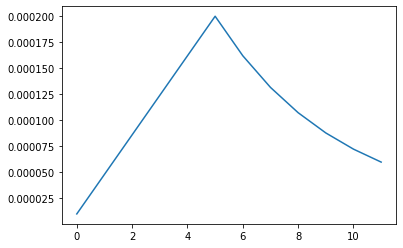

In [6]:
# 장비별 하이퍼파라미터 셋팅: 본 예제에 사전 세팅된 값이므로 적당히 바꿔서 사용

EPOCHS = 12

if strategy.num_replicas_in_sync == 8 or len(gpus) > 1: # TPU or Multi GPUs
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
    
elif strategy.num_replicas_in_sync == 1: # GPU
    BATCH_SIZE = 48 #16
    VALIDATION_BATCH_SIZE = 48 #16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
    
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

    
def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

Four images sizes are available for this dataset

In [0]:
# Data Check

IMAGE_SIZE = [331, 331]

FLOWERS_DATASETS = { # available image sizes
    192: 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec',
    224: 'gs://flowers-public/tfrecords-jpeg-224x224/*.tfrec',
    331: 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec',
    512: 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"

In [8]:
## GPU로 할 때는 GCP를 굳이 안써도 되므로 VM으로 Copy해서 사용하는 코드로 전환함
## 필요한 TFRecord 파일을 VM으로 Copy
!gsutil cp 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec' ./

Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers00-230.tfrec...
Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers01-230.tfrec...
Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers02-230.tfrec...
Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers03-230.tfrec...
\ [4 files][ 52.9 MiB/ 52.9 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers04-230.tfrec...
Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers05-230.tfrec...
Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers06-230.tfrec...
Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers07-230.tfrec...
Copying gs://flowers-public/tfrecords-jpeg-331x331/flowers08-230.tfrec...
C

## Read images and labels from TFRecords

In [9]:
# tfrecord이름에 포함된 파일 개수 counting하는 함수
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

# Split train data and validation data
gcs_pattern = FLOWERS_DATASETS[IMAGE_SIZE[0]]
validation_split = 0.19

# GCP 버킷에 있는 파일을 쓸 때
#filenames = tf.io.gfile.glob(gcs_pattern)
# VM Local에 있는 파일을 쓸 때
filenames = tf.io.gfile.glob('./*.tfrec')

split = len(filenames) - int(len(filenames) * validation_split)
TRAIN_FILENAMES = filenames[:split]
VALID_FILENAMES = filenames[split:]

# Keras로 학습할 때 필요한 train_steps 계산
TRAIN_STEPS = count_data_items(TRAIN_FILENAMES) // BATCH_SIZE
print("TRAINING IMAGES: ", count_data_items(TRAIN_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALID_FILENAMES))

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  62
VALIDATION IMAGES:  680


## training and validation datasets

TFRecord 파일 기반 DataSet 생성

In [0]:
## TFRecord 파일 Parsing 
#### TFRecord 생성 코드 참고해서 정의함
#### TFRecord에 포함된 데이터들 중 필요한 것들만 Return
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)  
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range    
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class
    

  
def force_image_sizes(dataset, image_size):
    # explicit size will be needed for TPU
    reshape_images = lambda image, label: (tf.reshape(image, [*image_size, 3]), label)
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset, IMAGE_SIZE)
    return dataset

def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class

def make_NCHW(image, one_hot_class):
    image = tf.transpose(image, [2, 0, 1]) # HWC -> CHW
    return image, one_hot_class  
# For experts: fine adjustments of tf.data.Dataset distribution behavior:

# Replicating a datset with state (even random number generator state) does not replicate the
# state and changes the behavior of the dataset. If the state is just the RNG state, it usually
# does not matter but this behavior can be adjusted with tf.data.experimental.ExternalStatePolicy:
#  WARN = 0   (this is the default in Tensorflow outside of Keras)
#  IGNORE = 1 (this is the default in Keras)
#  FAIL = 2

# On TPU pods, the dataset API attempts to shard the dataset across individual TPUs at the file
# level so that TPUs only load the data they will actually train on. This requires more data files 
# than TPUs in the pod. (ex: TPU v3-32 pod = 4 TPUs => dataset must have at least 4 files)
# An error will occur if there are not enough data files. File-level sharding can be disabled:
#  opt = tf.data.Options()
#  opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
#  dataset = dataset.with_options(opt)
   

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    #dataset = dataset.map(make_NCHW, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES)
    #dataset = dataset.map(make_NCHW, num_parallel_calls=AUTO)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    # needed for TPU 32-core pod: the test dataset has only 3 files but there are 4 TPUs. FILE sharding policy must be disabled.
    opt = tf.data.Options()
    opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    dataset = dataset.with_options(opt)
    
    return dataset

In [0]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

생성된 DataSet 확인

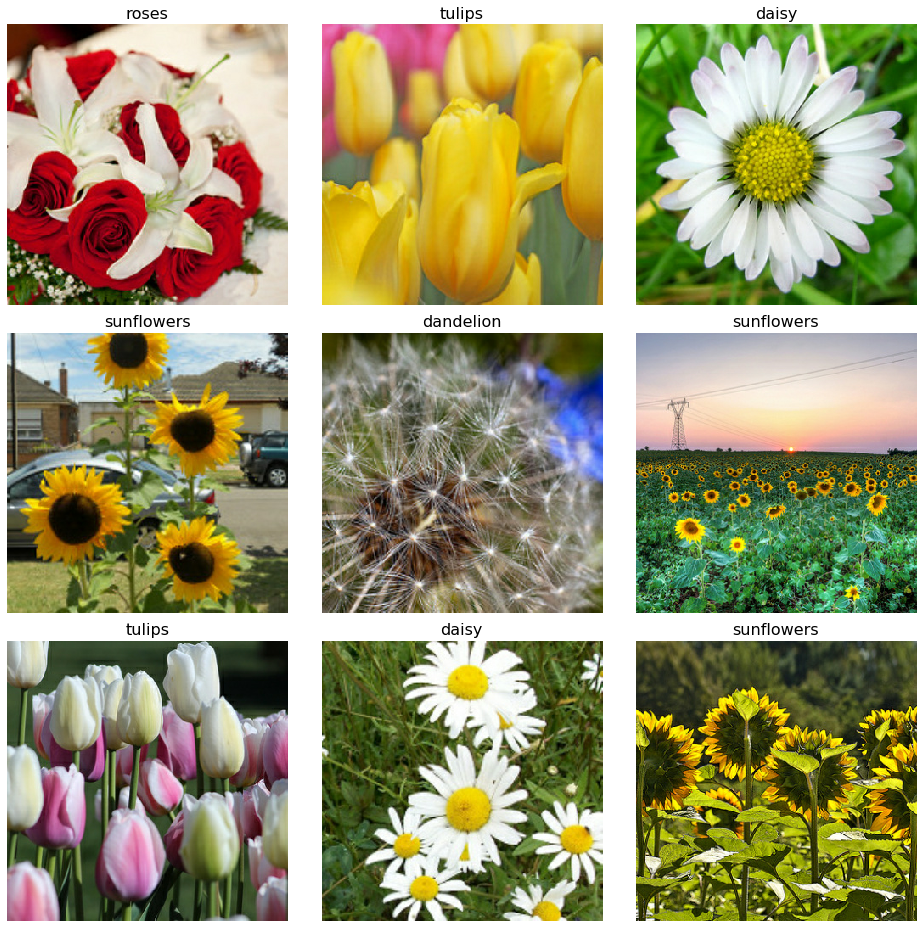

In [12]:
display_9_images_from_dataset(validation_dataset)

## Model

In [0]:
def create_model():
    #pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True
    
    '''
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    '''
    # GradCAM같이 pretraind model의 중간 레이어가 필요할 경우에는 Functional하게 정의해줍니다.
    x = pretrained_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    predictions = tf.keras.layers.Dense(5, activation='softmax', name='prediction') (x)
    model = tf.keras.Model(inputs=pretrained_model.input, outputs=predictions)
    
    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [14]:
with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = create_model()
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 165, 165, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 165, 165, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 165, 165, 32) 0           block1_conv1_bn[0][0]            
_____________________________

## Training

In [0]:
import os 

model_dir = './'
ckpt_full_path = os.path.join(model_dir, 'model.ckpt-{epoch:04d}')
callbacks = [
    lr_callback,
    tf.keras.callbacks.TensorBoard(log_dir = model_dir),
    tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_full_path,
                                       save_weights_only=True),
]

In [16]:
print ('BATCH_SIZE: ', BATCH_SIZE)
start_time = time.time()
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=callbacks)
#history = model.fit(training_dataset, validation_data=validation_dataset,
#                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

BATCH_SIZE:  48
Train for 62 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/12
62/62 [==============================] - 98s 2s/step - loss: 1.3888 - accuracy: 0.4929 - val_loss: 1.1770 - val_accuracy: 0.6838

Epoch 00002: LearningRateScheduler reducing learning rate to 4.8e-05.
Epoch 2/12
62/62 [==============================] - 81s 1s/step - loss: 0.5570 - accuracy: 0.8807 - val_loss: 0.3019 - val_accuracy: 0.9132

Epoch 00003: LearningRateScheduler reducing learning rate to 8.6e-05.
Epoch 3/12
62/62 [==============================] - 81s 1s/step - loss: 0.1755 - accuracy: 0.9519 - val_loss: 0.1645 - val_accuracy: 0.9485

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000124.
Epoch 4/12
62/62 [==============================] - 81s 1s/step - loss: 0.0800 - accuracy: 0.9788 - val_loss: 0.1265 - val_accuracy: 0.9559

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000162.
Epoch 5/12
62/62 [==============================] 

In [20]:
ls model*

model.ckpt-0001.data-00000-of-00002  model.ckpt-0007.data-00000-of-00002
model.ckpt-0001.data-00001-of-00002  model.ckpt-0007.data-00001-of-00002
model.ckpt-0001.index                model.ckpt-0007.index
model.ckpt-0002.data-00000-of-00002  model.ckpt-0008.data-00000-of-00002
model.ckpt-0002.data-00001-of-00002  model.ckpt-0008.data-00001-of-00002
model.ckpt-0002.index                model.ckpt-0008.index
model.ckpt-0003.data-00000-of-00002  model.ckpt-0009.data-00000-of-00002
model.ckpt-0003.data-00001-of-00002  model.ckpt-0009.data-00001-of-00002
model.ckpt-0003.index                model.ckpt-0009.index
model.ckpt-0004.data-00000-of-00002  model.ckpt-0010.data-00000-of-00002
model.ckpt-0004.data-00001-of-00002  model.ckpt-0010.data-00001-of-00002
model.ckpt-0004.index                model.ckpt-0010.index
model.ckpt-0005.data-00000-of-00002  model.ckpt-0011.data-00000-of-00002
model.ckpt-0005.data-00001-of-00002  model.ckpt-0011.data-00001-of-00002
model.ckpt-0005.index             

In [18]:
ls train

events.out.tfevents.1582189139.f5f6d1e705aa.142.5345.v2    plugins/
events.out.tfevents.1582189158.f5f6d1e705aa.profile-empty


In [19]:
ls validation/

events.out.tfevents.1582189236.f5f6d1e705aa.142.15067.v2


In [17]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

NameError: ignored

## Predictions

In [0]:
# a couple of images to test predictions too
some_flowers, some_labels = dataset_to_numpy_util(validation_dataset, 160)

In [0]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

display_9_images_with_predictions(some_flowers, predictions, some_labels)

## Save the model

In [0]:
save_model = create_model()
save_model.set_weights(model.get_weights())
save_model.save('model.h5')

## Reload the model

In [0]:
reload_model = tf.keras.models.load_model('model.h5')

predictions = reload_model.predict(some_flowers, batch_size=16)
evaluations = reload_model.evaluate(some_flowers, some_labels, batch_size=16)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)
display_9_images_with_predictions(some_flowers, predictions, some_labels)



---


author: Martin Gorner<br>
twitter: @martin_gorner


---


Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---


This is not an official Google product but sample code provided for an educational purpose


In [0]:
dataset = validation_dataset.unbatch().batch(10)
i=0
for images, labels in dataset:
  numpy_images = images.numpy()
  numpy_labels = labels.numpy()
  i += numpy_labels.shape[0]
  
  
  #break;  
print (i)

680
